# Building AI-powered search in PostgreSQL using Amazon SageMaker and pgvector
_**Using a pretrained LLM and PostgreSQL extension `pgvector` for similarity search on product catalog**_

---

---

## Contents


1. [Background](#Background)
1. [Setup](#Setup)
1. [Language Translation](#Language-Translation)
1. [SageMaker Model Hosting](#SageMaker-Model-Hosting)
1. [Load data into PostgreSQL](#PostgreSQL-vector-extension)
1. [Evaluate Search Results](#Evaluate-PostgreSQL-vector-Search-Results)

## Background

In this notebook, we'll build the core components of a textually similar Products. Often people don't know what exactly they are looking for and in that case they just type an item description and hope it will retrieve similar items.

One of the core components of searching textually similar items is a fixed length sentence/word embedding i.e. a  “feature vector” that corresponds to that text. The reference word/sentence embedding typically are generated offline and must be stored so they can be efficiently searched. In this use case we are using a pretrained SentenceTransformer model `all-MiniLM-L6-v2` from [HuggingFace Transformers](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

To enable efficient searches for textually similar items, we'll use Amazon SageMaker to generate fixed length sentence embeddings i.e “feature vectors” and use the Nearest Neighbor search in RDS for PostgreSQL using the extension `pgvector`. The PostgreSQL `pgvector` extension lets you store and search for points in vector space and find the "nearest neighbors" for those points. Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

Here are the steps we'll follow to build textually similar items: After some initial setup, we'll host the pretrained language model in SageMaker. Then generate feature vectors for Fashion products from *__feidegger__*, a *__zalandoresearch__* dataset. Those feature vectors will be stored in RDS for PostgreSQL vector datatype. Next, we'll explore some sample text queries, and visualize the results.

## Setup
Install required python libraries for the workshop


In [1]:
!pip install -U psycopg2-binary pgvector tqdm boto3 requests scikit-image

### Downloading Zalando Research data

The dataset itself consists of 8,732 high-resolution images, each depicting a dress from the available on the Zalando shop against a white-background. Each of the images has five textual annotations orinally in German and are translated to english, each of which has been generated by a separate user. 

**Downloading Zalando Research data**: Data originally from here: https://github.com/zalandoresearch/feidegger 

 **Citation:** <br>
 https://github.com/zalandoresearch/feidegger <br>
 *@inproceedings{lefakis2018feidegger,* <br>
 *title={FEIDEGGER: A Multi-modal Corpus of Fashion Images and Descriptions in German},* <br>
 *author={Lefakis, Leonidas and Akbik, Alan and Vollgraf, Roland},* <br>
 *booktitle = {{LREC} 2018, 11th Language Resources and Evaluation Conference},* <br>
 *year      = {2018}* <br>
 *}*

In [5]:
import urllib.request
import os
import json
import boto3
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map
filename = 'metadata.json'

def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

## The German text has been translated into English and the resulting translation has been stored in this repository for convenience.
download_metadata('https://raw.githubusercontent.com/aws-samples/rds-postgresql-pgvector/master/data/FEIDEGGER_release_1.2.json')

with open(filename) as json_file:
    results = json.load(json_file)

results[0]

## SageMaker Model Hosting

In this section will deploy the pretrained `all-MiniLM-L6-v2` Hugging Face SentenceTransformer model into SageMaker and generate 384 dimensional vector embeddings for our product catalog descriptions.


In [8]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

In [9]:
from sagemaker.huggingface.model import HuggingFaceModel

# Hub Model configuration. <https://huggingface.co/models>
hub = {
  'HF_MODEL_ID': 'sentence-transformers/all-MiniLM-L6-v2',
  'HF_TASK': 'feature-extraction'
}

# Deploy Hugging Face Model 
predictor = HuggingFaceModel(
               env=hub, # configuration for loading model from Hub
               role=role, # iam role with permissions to create an Endpoint
               transformers_version='4.26',
               pytorch_version='1.13',
               py_version='py39',
            ).deploy(
               initial_instance_count=1,
               instance_type="ml.m5.xlarge",
               endpoint_name="rdspg-vector"
            )
print(f"Hugging Face Model has been deployed successfully to SageMaker")


In [10]:
def cls_pooling(model_output):
    #First element of model_output contains all token embeddings
    return [sublist[0] for sublist in model_output][0]

data = {
  "inputs": ' '.join(results[0].get('descriptions'))
}

res = cls_pooling( predictor.predict(data=data) )
print (len(res))


In [11]:
# Please re-run the cell if it fails.
# Perform a job using realtime inference to generate embeddings ~30 min.

def generate_embeddings(data):
    r = {}
    r['url'] = data['url']
    r['descriptions'] = data['descriptions']
    r['split'] = data['split']
    inp = {'inputs' : ' '.join( data['descriptions'] ) }
    vector = cls_pooling( predictor.predict(inp) )
    r['descriptions_embeddings'] = vector
    return r
    
workers = 1 * cpu_count()

chunksize = 32

#Generate Embeddings
data = process_map(generate_embeddings, results, max_workers=workers, chunksize=chunksize)

data[0]

In [12]:
len(data[0].get('descriptions_embeddings'))

## Open-source extension pgvector in PostgreSQL

pgvector is an open-source extension for PostgreSQL that allows you to store and search vector embeddings for exact and approximate nearest neighbors. It is designed to work seamlessly with other PostgreSQL features, including indexing and querying.

One of the key benefits of using pgvector is that it allows you to perform similarity searches on large datasets quickly and efficiently. This is particularly useful in industries like e-commerce, where businesses need to be able to quickly search through large product catalogs to find the items that best match a customer's preferences. It supports exact and approximate nearest neighbor search, L2 distance, inner product, and cosine distance.

To further optimize your searches, you can also use pgvector's indexing features. By creating indexes on your vector data, you can speed up your searches and reduce the amount of time it takes to find the nearest neighbors to a given vector.

In this step we'll get all the translated product descriptions of *__zalandoresearch__* dataset and store those embeddings into PostgreSQL vector type.

In [13]:
import psycopg2
from pgvector.psycopg2 import register_vector
import boto3 
import json 

client = boto3.client('secretsmanager')

response = client.get_secret_value(
    SecretId='rdspg-vector-secret'
)
database_secrets = json.loads(response['SecretString'])

dbhost = database_secrets['host']
dbport = database_secrets['port']
dbuser = database_secrets['username']
dbpass = database_secrets['password']

dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, connect_timeout=10)
dbconn.set_session(autocommit=True)

cur = dbconn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
register_vector(dbconn)
cur.execute("DROP TABLE IF EXISTS products;")
cur.execute("""CREATE TABLE IF NOT EXISTS products(
               id bigserial primary key, 
               description text, 
               url text, 
               split int, 
               descriptions_embeddings vector(384));""")

for x in data:
    cur.execute("""INSERT INTO products
                      (description, url, split, descriptions_embeddings) 
                  VALUES(%s, %s, %s, %s);""", 
                  (' '.join(x.get('descriptions', [])), x.get('url'), x.get('split'), x.get('descriptions_embeddings') ))

cur.execute("""CREATE INDEX ON products 
               USING ivfflat (descriptions_embeddings vector_l2_ops) WITH (lists = 100);""")
cur.execute("VACUUM ANALYZE products;")

cur.close()
dbconn.close()
print ("Vector embeddings has been successfully loaded into PostgreSQL")
     

## Evaluate PostgreSQL vector Search Results

In this step we will use SageMaker realtime inference to generate embeddings for the query and use the embeddings to search the PostgreSQL to retrive the nearest neighbours and retrive the relevent product images.


Product Item Id: 4712


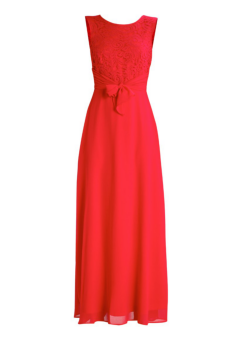

Product Item Id: 101


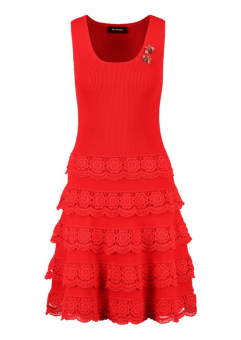

In [15]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import requests

data = {"inputs": "red sleeveless summer wear"}

res1 = cls_pooling( predictor.predict(data=data) )

client = boto3.client('secretsmanager')

response = client.get_secret_value(
    SecretId='rdspg-vector-secret'
)
database_secrets = json.loads(response['SecretString'])

dbhost = database_secrets['host']
dbport = database_secrets['port']
dbuser = database_secrets['username']
dbpass = database_secrets['password']

dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, connect_timeout=10)
dbconn.set_session(autocommit=True)
cur = dbconn.cursor()

cur.execute("""SELECT id, url, description, descriptions_embeddings 
            FROM products 
            ORDER BY descriptions_embeddings <-> %s limit 2;""", 
            (np.array(res1),))

r = cur.fetchall()
urls = []
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for x in r:
    #print (x)
    url = x[1].split('?')[0]
    urldata = requests.get(url).content
    print ("Product Item Id: " + str(x[0]))
    a = io.imread(url)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

cur.close()
dbconn.close()


In [16]:
# Cleanup
predictor.delete_model()
predictor.delete_endpoint()